In [1]:
# the fast.ai library
from fastai import *
from fastai.vision import *
from PIL import Image
import os 
from pathlib import Path

In [2]:
INPUT = Path("./input/digit-recognizer")

In [3]:
os.listdir(INPUT)

['train.csv', 'sample_submission.csv', 'test.csv']

In [4]:
train_df = pd.read_csv(INPUT/"train.csv")
train_df.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df =  pd.read_csv(INPUT/"test.csv")
test_df.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
TRAIN = Path("./train")
TEST = Path("./test")

In [7]:
# Create training directory
for index in range(10):
    try:
        os.makedirs(TRAIN/str(index))
    except:
        pass

In [8]:
sorted(os.listdir(TRAIN))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [9]:
# create the test directory 
try: 
    os.makedirs(TEST)
except:
    pass


In [10]:
# transforms
tfms = get_transforms(do_flip=False, max_zoom=1.2)

In [11]:
data = ImageDataBunch.from_folder(
    path = ".",
    train = 'train',
    test = "test",
    valid_pct = 0.2,
    bs = 32,
    size = 28,
    ds_tfms = tfms,
    #num_workers = 0
)

In [12]:
data.normalize(mnist_stats)

ImageDataBunch;

Train: LabelList (33600 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
6,6,6,6,6
Path: .;

Valid: LabelList (8400 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
2,8,7,6,5
Path: .;

Test: LabelList (28000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: .

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir="/tmp/models", callback_fns=ShowGraph)

In [14]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

epoch,train_loss,valid_loss,accuracy,time
0,0.971569,0.632675,0.803929,00:22
1,0.445793,0.281459,0.911071,00:22
2,0.305555,0.167215,0.945476,00:22
3,0.247276,0.128337,0.962024,00:22
4,0.229013,0.116924,0.963929,00:22


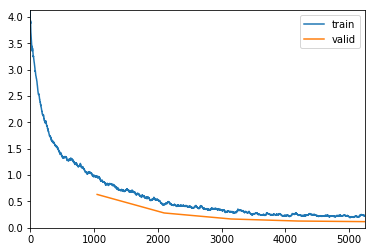

In [15]:
learn.fit_one_cycle(cyc_len=5)

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

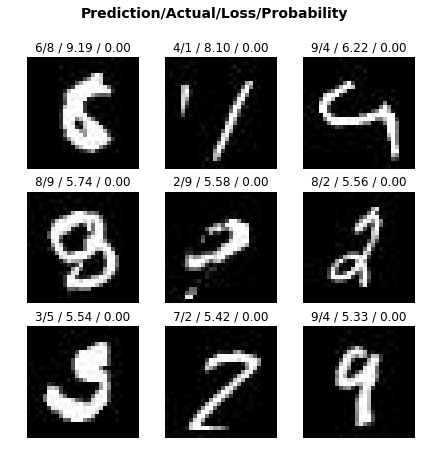

In [17]:
interp.plot_top_losses(9, figsize=(7, 7))

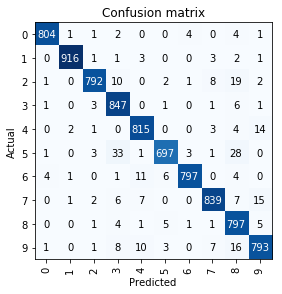

In [18]:
interp.plot_confusion_matrix()

In [19]:
class_score, y = learn.get_preds(DatasetType.Test)

In [20]:
class_score

tensor([[4.0458e-05, 2.7663e-04, 9.9905e-01,  ..., 1.0029e-04, 4.5223e-05,
         2.7401e-06],
        [9.9985e-01, 1.0580e-06, 4.3692e-05,  ..., 2.3566e-05, 1.0361e-05,
         5.3442e-05],
        [1.6434e-03, 7.7370e-05, 6.0778e-03,  ..., 1.7370e-03, 1.5251e-02,
         1.7518e-02],
        ...,
        [4.4423e-09, 3.9920e-08, 2.1780e-05,  ..., 3.9431e-07, 1.1040e-06,
         6.6009e-07],
        [1.6950e-02, 2.4924e-02, 2.1659e-02,  ..., 7.8395e-03, 4.9213e-02,
         6.5762e-02],
        [3.1213e-05, 9.9911e-01, 2.0946e-04,  ..., 6.2669e-04, 7.2591e-06,
         5.1742e-06]])

In [21]:
class_score.shape

torch.Size([28000, 10])

In [22]:
y

tensor([0, 0, 0,  ..., 0, 0, 0])

In [23]:
predictions = np.argmax(class_score, axis=1)
# convert to list 
predictions = predictions.tolist()

In [24]:
len(predictions)

28000

In [25]:
# remove file extension from filename
ImageID = [os.path.splitext(path)[0] for path in os.listdir(TEST)]
# typecast to int so that file can be sorted by ImageId
ImageID = [int(id) for id in ImageID]
# +1 because index starts at 1 in the submission file
ImageID = [id+1 for id in ImageID]

In [26]:
len(ImageID)

28000

In [27]:
submission  = pd.DataFrame({
    "ImageId": ImageID,
    "Label": predictions
})

In [29]:
# submission.sort_values(by=["ImageId"], inplace = True)
submission.to_csv("./submission.csv", index=False)
display(submission.head(3))
display(submission.tail(3))

,ImageId,Label
0,14308,2
1,17921,0
2,21118,5


,ImageId,Label
27997,4056,3
27998,5958,5
27999,17349,1
